In [1]:
import os
import utilities as rocku
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
import timeit
from pystackreg import StackReg
from PIL import Image
import dxchange
from tqdm import tqdm
# from skimage.transform import rescale
import skimage as ski
ncore = mp.cpu_count()
print("CPU cores:", ncore)

CPU cores: 256


In [3]:
# need to change
ipts="30610"
# scan_type = 'ct_scans'
# scan_type = 'radiographs'
scan_type = 'processed_data/normalized'
# scan_type = 'analysis'
# scan_type = 'analysis'
####################################
##################################
scan_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/" + scan_type
save_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/analysis/"
folder_list = os.listdir(scan_loc)
folder_list.sort()
folder_list

['2023_08_01_dehydration',
 '2023_08_01_hydration',
 '2023_08_03_calibration',
 '2023_08_03_dehydration2',
 '2023_08_03_hydration',
 '2023_08_03_throughflow',
 '2023_08_03_throughflow_td_b_h',
 '2023_08_07',
 '2023_08_07_calibration']

In [103]:
sample_name = "2023_08_03_throughflow_td_b_h"
######################
######################
######################
scan_dir = os.path.join(scan_loc, sample_name)
fname_list = os.listdir(scan_dir)
fname_list.sort()
fname_list

['20230807_hydrated_straight_0030_0028.tiff',
 '20230807_hydrated_straight_0030_0029.tiff',
 '20230807_hydrated_straight_0030_0030.tiff',
 '20230807_hydrated_straight_0030_0031.tiff',
 '20230807_hydrated_straight_0030_0032.tiff']

In [94]:
to_rmv = [
# '01_heat_hold_at_400_0030_0001.tiff',
#  '01_heat_hold_at_400_0030_0006.tiff',
#  '01_heat_hold_at_400_0030_0011.tiff',
#  '02_heating_at_800_0030_0001.tiff',
#  '02_heating_at_800_0030_0006.tiff',
#  '02_heating_at_800_0030_0011.tiff',
#  '02_heating_at_800_0030_0016.tiff',
]
fname_list = rocku.remove_fnames(fname_list, to_rmv)
fname_list

158
158


['20230804_throughflowreactor_bot_hyd_top_dhyd2_0030_5495.tiff',
 '20230804_throughflowreactor_bot_hyd_top_dhyd2_0030_5496.tiff',
 '20230804_throughflowreactor_bot_hyd_top_dhyd2_0030_5497.tiff',
 '20230804_throughflowreactor_bot_hyd_top_dhyd2_0030_5498.tiff',
 '20230804_throughflowreactor_bot_hyd_top_dhyd2_0030_5499.tiff',
 '20230804_throughflowreactor_bot_hyd_top_dhyd2_0030_5500.tiff',
 '20230804_throughflowreactor_bot_hyd_top_dhyd2_0030_5501.tiff',
 '20230804_throughflowreactor_bot_hyd_top_dhyd2_0030_5502.tiff',
 '20230804_throughflowreactor_bot_hyd_top_dhyd2_0030_5503.tiff',
 '20230804_throughflowreactor_bot_hyd_top_dhyd2_0030_5504.tiff',
 '20230804_throughflowreactor_bot_hyd_top_dhyd2_0030_5505.tiff',
 '20230804_throughflowreactor_bot_hyd_top_dhyd2_0030_5506.tiff',
 '20230804_throughflowreactor_bot_hyd_top_dhyd2_0030_5507.tiff',
 '20230804_throughflowreactor_bot_hyd_top_dhyd2_0030_5508.tiff',
 '20230804_throughflowreactor_bot_hyd_top_dhyd_0030_5351.tiff',
 '20230804_throughflowreac

In [95]:
img_stack = rocku.read_img_stack(scan_dir, fname_list, flipud=False)
trans_algo_dict = {
    'TRANSLATION': StackReg.TRANSLATION,
    'RIGID_BODY': StackReg.RIGID_BODY,
    'SCALED_ROTATION': StackReg.SCALED_ROTATION,
    'AFFINE': StackReg.AFFINE,
    'BILINEAR': StackReg.BILINEAR
}

158it [00:00, 248.50it/s]


Text(0.5, 1.0, 'last/first')

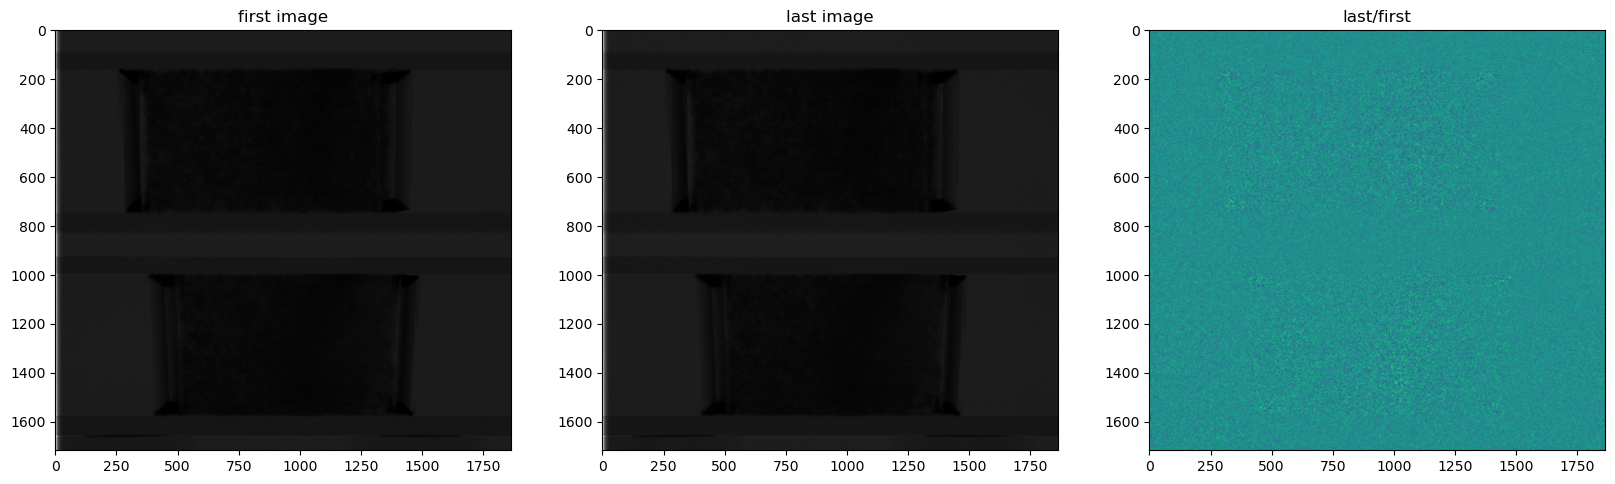

In [96]:
f, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img_stack[0], cmap='gray')#vmin=0, vmax=1,
ax[0].set_title('first image')

ax[1].imshow(img_stack[-1], cmap='gray')
ax[1].set_title('last image')

ax[2].imshow(np.divide(img_stack[-1], img_stack[0]), vmin=0.8, vmax=1.2)
ax[2].set_title('last/first')

Text(0.5, 1.0, 'overlay (reference=green, changed=red)')

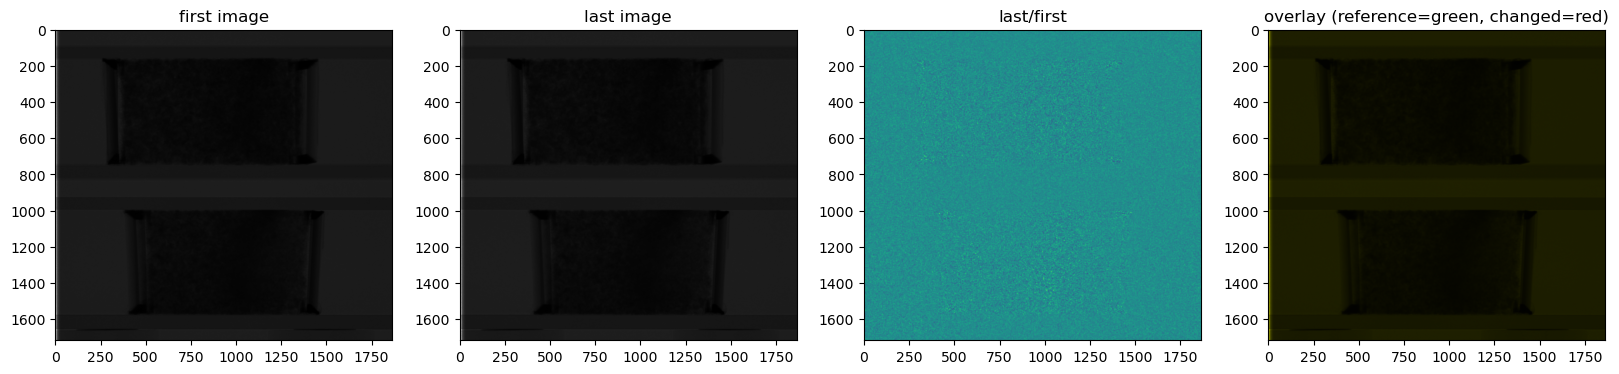

In [97]:
# roi = True
roi = False
roi_left = 0
roi_right = -1
roi_top = 0
roi_bottom = 900
# roi_left = 250
# roi_right = 1350
# roi_top = 900
# roi_bottom = 1350
#########################
#########################
img_stack_roi = rocku.crop(img_stack, roi_left, roi_right, roi_top, roi_bottom, roi)
f, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].imshow(img_stack_roi[0], cmap='gray')# vmin=0, vmax=1)
ax[0].set_title('first image')

ax[1].imshow(img_stack_roi[-1], cmap='gray')# vmin=0, vmax=1)
ax[1].set_title('last image')

ax[2].imshow(np.divide(img_stack_roi[-1], img_stack_roi[0]), vmin=0.8, vmax=1.2)
ax[2].set_title('last/first')

ax[3].imshow(rocku.composite_images([img_stack_roi[0], img_stack_roi[-1]]))
ax[3].set_title('overlay (reference=green, changed=red)')
# ax[3].axis('off');

In [98]:
pixel_bin_size = 1
# pixel_bin_size = 2
func = np.sum
# dtype = np.float16
dtype = np.float32
# dtype = np.float64
#################################################
t0 = timeit.default_timer()
img_stack_resized = rocku.bin_pix(img_stack_roi, pixel_bin_size=pixel_bin_size, func=func, dtype=dtype)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

Pixel_bin_size = 1, no binning
Time: 6.316000144579448e-05 s


In [99]:
perform_reg = False
# perform_reg = True
trans_algo = 'RIGID_BODY'
# trans_algo = 'TRANSLATION'
# trans_algo = "SCALED_ROTATION"
#########################
#load reference and "moved" image
random_idx = None
if perform_reg:
    ref = img_stack_resized[0]
    mov = img_stack_resized[-1]
    sr = StackReg(trans_algo_dict[trans_algo])
    reg = sr.register_transform(ref, mov)
    reg = reg.clip(min=0)
    after_reg = rocku.composite_images([ref, reg])
    before_reg = rocku.composite_images([ref, mov])
    
    f, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(np.divide(mov, ref), vmin=0.8, vmax=1.2)
    ax[0].set_title('last/first (unregistered)')
    
    ax[1].imshow(np.divide(reg, ref), vmin=0.8, vmax=1.2)
    ax[1].set_title('last/first (registered)')
    
    ax[2].imshow(before_reg)
    ax[2].set_title('overlay (reference=green, changed=red)')
    
    ax[3].imshow(after_reg)
    ax[3].set_title('overlay (reference=green, changed=red)')

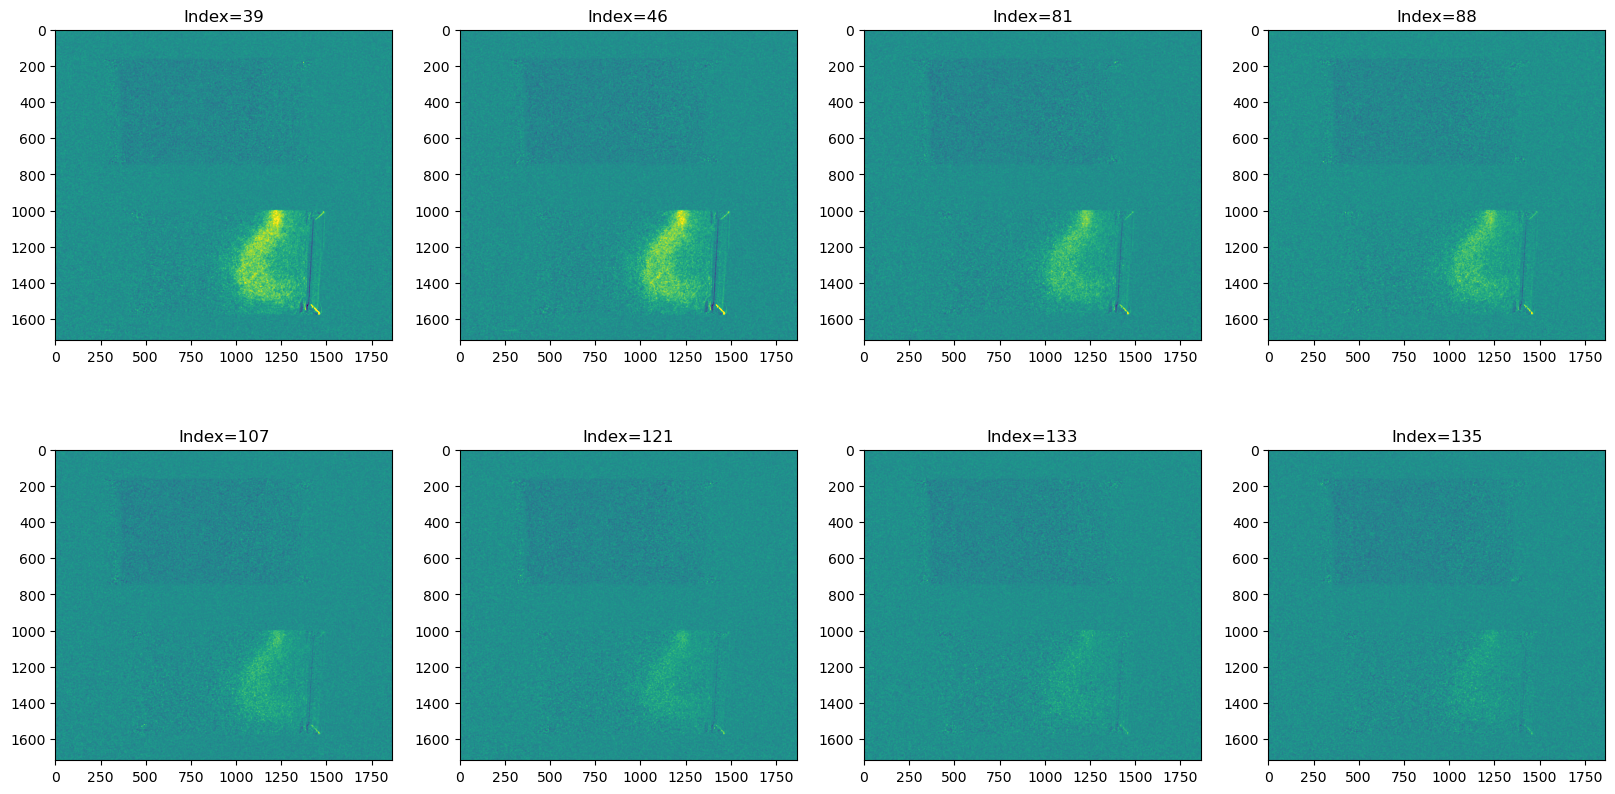

In [100]:
reference = 'previous'
# reference = 'first'
# reference = 'mean'
moving_avg = 1
n_frames = 1
init_avg_size = 5
#################################################
if perform_reg:
    sr = StackReg(trans_algo_dict[trans_algo])
    reg_stack_roi = sr.register_transform_stack(img_stack_resized, reference=reference, n_frames=n_frames, moving_average=moving_avg, verbose=True)#, progress_callback=rocku.show_progress)
else:
    reg_stack_roi = img_stack_resized[:]
if init_avg_size > 1:
    reg_ratio = np.divide(reg_stack_roi, np.mean(reg_stack_roi[0:init_avg_size-1,:,:], axis=0))
else:
    reg_ratio = np.divide(reg_stack_roi, reg_stack_roi[0])
if random_idx is None:
    num_of_row = 2
    fig_per_row = 4
    random_idx = rocku.generate_randint_list(num_of_ele=fig_per_row*num_of_row, range_min=0, range_max=len(reg_ratio))
fig_size = (20,10)
vmin=0.8
vmax=1.2
rocku.plot_imgs_from_stack(reg_ratio, random_idx, vmin=vmin, vmax=vmax, fig_per_row=fig_per_row, figsize=fig_size)

# reference = 'previous'
reference = 'first'
###############################################
reg_dict = {}
sr = StackReg(trans_algo_dict[trans_algo])
print("Registration using '{}'".format(ref_name))
tmats = sr.register_stack(unreg_dict[ref_name], reference=reference, progress_callback=rocku.show_progress)
for ee in unreg_dict.keys():
    print("Apply transform to {}".format(ee))
    reg_dict[ee] = sr.transform_stack(unreg_dict[ee], tmats=tmats)

# Crop

In [101]:
###################### need to change start
crop = False
# crop_left = 250
# crop_right = 1650
# crop_top = 750
# crop_bottom = 1950
crop_left = 450
crop_right = 1200
crop_top = 1750#530
crop_bottom = 2190
###################### need to change end
reg_ratio_out = rocku.crop(reg_ratio, crop_left, crop_right, crop_top, crop_bottom, crop)
if crop:
    print("Cropped:")
    plt.imshow(reg_ratio_out[-1])
    plt.colorbar()
    plt.show()

# Save files

In [102]:
# name_str = 'RT'
name_str = None
############################################################
dir_name_list = [sample_name, name_str, trans_algo, reference]
if name_str is None:
    dir_name_list.remove(name_str)
if not perform_reg:
    dir_name_list.remove(trans_algo)
    dir_name_list.remove(reference)

save_to = save_loc + "_".join(dir_name_list)
save_to_norm = save_to + '/normalized'
if perform_reg:
    save_to_ratio = save_to + '/ratio'
else:
    save_to_ratio = save_to + '_ratio'

if crop:
    reg_stack_subdir = save_to_norm + "/full"
    reg_ratio_subdir = save_to_ratio + "/full"
    reg_stack_crop_subdir = save_to_norm + "/crop"
    reg_ratio_crop_subdir = save_to_ratio + "/crop"
else:
    reg_stack_subdir = save_to_norm
    reg_ratio_subdir = save_to_ratio

reg_stack_out = reg_stack_roi
reg_stack_crop_out = rocku.crop(reg_stack_roi, crop_left, crop_right, crop_top, crop_bottom, crop)
###############################
###############################
if perform_reg:
    if not os.path.exists(save_to):
        os.mkdir(save_to)
    if not os.path.exists(save_to_norm):
        os.mkdir(save_to_norm)
    if not os.path.exists(reg_stack_subdir):
        os.mkdir(reg_stack_subdir)
    print("Saving to '{}' ...".format(reg_stack_subdir))
if not os.path.exists(save_to_ratio):
    os.mkdir(save_to_ratio)
if not os.path.exists(reg_ratio_subdir):
    os.mkdir(reg_ratio_subdir)
print("Saving to '{}' ...".format(reg_ratio_subdir))
for i, e_name in tqdm(enumerate(fname_list)):
    if perform_reg:
        img_pl = Image.fromarray(reg_stack_out[i])
        img_pl.save(reg_stack_subdir + "/" + e_name)
    img_pl_ratio = Image.fromarray(reg_ratio[i])
    img_pl_ratio.save(reg_ratio_subdir + "/" + e_name)
    if crop:
        if perform_reg:
            if not os.path.exists(reg_stack_crop_subdir):
                os.mkdir(reg_stack_crop_subdir)
                img_pl_crop = Image.fromarray(reg_stack_crop_out[i])
                img_pl_crop.save(reg_stack_crop_subdir + "/" + e_name)
        if not os.path.exists(reg_ratio_crop_subdir):
            os.mkdir(reg_ratio_crop_subdir)
        img_pl_ratio_crop = Image.fromarray(reg_ratio_out[i])
        img_pl_ratio_crop.save(reg_ratio_crop_subdir + "/" + e_name)
    

Saving to '/HFIR/CG1D/IPTS-30610/shared/analysis/2023_08_03_throughflow_td_b_h_ratio' ...


158it [00:04, 33.07it/s]
